# Infer a vehicle's position from ANPR camera observations

## Unconstrained map problem

Suppose a vehicle is not constrained by the road network, but instead can travel anywhere in a given bounded region. At certain locations within the region, an ANPR camera can detect the vehicle and generate an observation. The problem is to calculate the probability that the vehicle is at a given location within the region given the observations.

The region is a rectangle with $(x,y)$ coordinates where $x \in [0, x_{max})$ and $y \in [0, y_{max})$ with the units in metres.

There are $N_c$ cameras randomly distributed in the region. The positions of the cameras $C$ are held in a $N_c \times 2$ matrix. Each camera has the same observation radius $r$ and the observation regions of the cameras don't overlap. Each camera can perfectly detect whether the vehicle is within its detection radius, but it doesn't detect the vehicle's position within that circle. The camera detections are stored in a vector $D$ where each element is the index of the camera that made the detection.

In the simplest case, the vehicle is assumed to move at a constant speed $s$ (in m/s) over the region. It stays within the region, but it performs a random walk and thus can change direction at each time step. There are $N_t$ timesteps $t_i$ where $i \in \{0, 1, \ldots, N_{t-1}\}$. The state space of the vehicle $V$ is represented as a $N_t \times 3$ matrix, where each row is composed of $(x, y, \theta)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def random_position(x_max, y_max):
    """Random position on the (x,y) plane."""
    return (np.random.uniform(0, x_max), np.random.uniform(0, y_max))

In [3]:
def random_angle():
    return np.random.uniform(0, 2*np.pi)

In [4]:
def distance(p1, p2):
    """Returns the distance between points p1 and p2."""
    delta_x = p1[0] - p2[0]
    delta_y = p1[1] - p2[1]
    return np.sqrt(np.pow(delta_x,2) + np.pow(delta_y,2))

In [5]:
def generate_camera_positions(x_max, y_max, N_c, r):
    C = np.zeros((N_c, 2))

    # Set the first camera position
    C[0,:] = random_position(x_max, y_max)
    n_positions = 1

    while n_positions < N_c:
        # Randomly generate a position for the camera
        candidate = random_position(x_max, y_max)

        # Check if the observation circle of the candidate camera overlaps with
        # any other cameras
        overlap = False
        for i in range(n_positions):
            if distance(C[i,:], candidate) <= 2*r:
                overlap = True
                break

        if not overlap:
            C[n_positions,:] = candidate
            n_positions += 1

    return C

In [6]:
def in_bounding_box(position, x_max, y_max):
    return 0 <= position[0] < x_max and 0 <= position[1] < y_max

In [7]:
def position_along_line(state, s, delta_t):
    position = state[:2] + s * delta_t * np.array([np.cos(state[2]), np.sin(state[2])])
    return np.array([position[0], position[1], state[2]])

In [89]:
def move_vehicle(x_max, y_max, state, s, delta_t):
    candidate = np.array([-1, -1, -1])
    n_tries = 0
    while not in_bounding_box(candidate[:2], x_max, y_max) and n_tries < 10:
        # Check if moving the vehicle forward would cause it to leave the
        # bounding region
        forward_state = position_along_line(state, s, delta_t)
        if not in_bounding_box(forward_state[:2], x_max, y_max):
            candidate[:2] = state[:2]
            candidate[2] = state[2] - np.pi
        else:
            revised_state = state[:]
            if np.random.rand() > 0.7:
                revised_state[2] = state[2] + 0.5 * np.random.standard_normal()
        
            candidate = position_along_line(revised_state, s, delta_t)
    
        n_tries += 1

    assert n_tries < 11
    

    return candidate

In [90]:
def generate_vehicle_positions(x_max, y_max, s, delta_t, N_t):
    V = np.zeros((N_t, 3))

    # Initial position and angle
    V[0,0:2] = random_position(x_max, y_max)
    V[0,2] = random_angle()

    for i in range(1, N_t):
        V[i,:] = move_vehicle(x_max, y_max, V[i-1,:], s, delta_t)

    return V

In [91]:
def detect_vehicle(C, V, r):
    N_c = C.shape[0]
    N_t = V.shape[0]
    D = np.zeros(N_t)

    for i in range(N_t):
        D[i] = np.nan
        for c in range(N_c):
            if distance(C[c,:], V[i,0:2]) <= r:
                D[i] = c
                break

    return D

In [92]:
# Bounds of the region
x_max = 100
y_max = 100

# Sample the camera positions
n_c = 10
r = 10
C = generate_camera_positions(x_max, y_max, n_c, r)

# Generate the vehicle positions
delta_t = 1
s = 1
N_t = 500
V = generate_vehicle_positions(x_max, y_max, s, delta_t, N_t)

# Generate the camera detections
D = detect_vehicle(C, V, r)

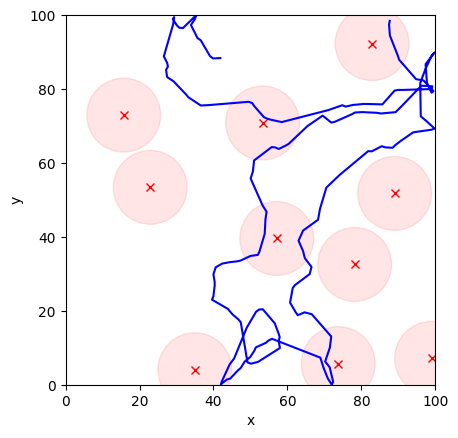

In [93]:
fig, ax = plt.subplots()

# Plot the camera positions and their observation circles
ax.plot(C[:,0], C[:,1], 'rx')
for i in range(n_c):
    circle = plt.Circle(( C[i,0] , C[i,1] ), r, color='r', alpha=0.1)
    ax.add_patch(circle)

# Plot the vehicle track
ax.plot(V[:,0], V[:,1], 'b')

# Set up the plot axes
ax.set_aspect('equal')
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

A simple particle filtering-based approach is used to calculate the probability that the vehicle is at a given location. There are $N_p$ particles and at each timestep the particle has an $(x,y)$ position and an angle. The state of a particle at a single timestep is held in an $N_p \times 3$ matrix. The state of all particles over all time is stored in an $N_t \times N_p \times 3$ array denoted $P$.

In [94]:
def random_point_in_circle(centre, r):
    theta = np.random.uniform(0, 2*np.pi)
    d = np.random.uniform(0, r)
    point = centre + d * np.array([np.cos(theta), np.sin(theta)])
    return point

In [95]:
def random_particles_in_circle(N_p, centre, r):
    P = np.zeros((N_p, 3))
    for p in range(N_p):
        P[p,0:2] = random_point_in_circle(centre, r)
        P[p,2] = random_angle()
    return P

In [96]:
from tqdm import tqdm

In [97]:
def run_particle_filter(N_p, N_t, x_max, y_max, D, C, r):
    P = np.zeros((N_t, N_p, 3))

    # Initialise the particles' positions
    for i in range(N_p):
        P[0,i,0:2] = random_position(x_max, y_max)
        P[0,i,2] = random_angle()

    # Walk through each time step
    for t in tqdm(range(N_t)):
        # If there is a camera detection at the time step, then the vehicle must
        # be in the detection circle of the camera that reported the detection
        if not np.isnan(D[t]):
            camera_index = int(D[t])
            P[t,0:N_p,0:3] = random_particles_in_circle(N_p, C[camera_index,:], r)
        else:
            for p in range(N_p):
                P[t,p,:] = move_vehicle(x_max, y_max, P[t-1,p,:], s, delta_t)

    return P

In [98]:
# Run the particle filter
N_p = 2
P = run_particle_filter(N_p, N_t, x_max, y_max, D, C, r)

100%|██████████| 500/500 [00:00<00:00, 5345.25it/s]


8.0


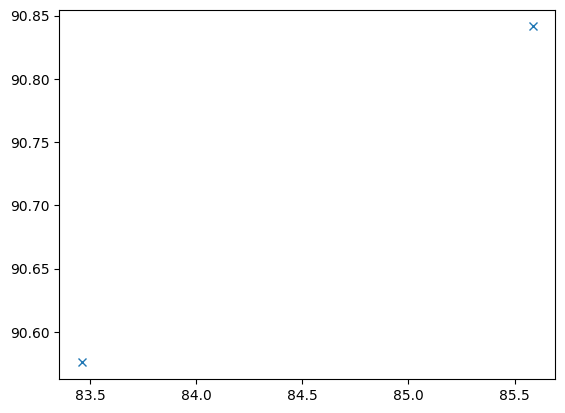

In [99]:
t = 8
print(D[t])
plt.plot(P[t,:,0], P[t,:,1], 'x')
plt.show()